### Imports & Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

pd.set_option("display.max_columns", None)
sns.set_style("whitegrid")

# Path to raw data
RAW_PATH = "../data/raw/healthcare-dataset-stroke-data.csv"

This section imports all the essential libraries for data analysis and visualization pandas, numpy, matplotlib, and seaborn and sets up the file path for loading our dataset.

### Load Dataset

In [3]:
# Load raw stroke dataset
df = pd.read_csv(RAW_PATH)
print(f"Dataset shape: {df.shape}")
print(f"\nColumns: {df.columns.tolist()}")
df.head()

Dataset shape: (5110, 12)

Columns: ['id', 'gender', 'age', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type', 'avg_glucose_level', 'bmi', 'smoking_status', 'stroke']


,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


The dataset contains 5,110 patient records with 12 health and demographic features, including numeric variables like age and glucose levels as well as categorical attributes such as gender and work type.

### Dataset Info

In [4]:
# Basic info
print("="*60)
print("DATASET OVERVIEW")
print("="*60)
print(f"Total records: {df.shape[0]:,}")
print(f"Total features: {df.shape[1]}")
print(f"\nColumn types:")
df.info()

DATASET OVERVIEW
Total records: 5,110
Total features: 12

Column types:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


Most features are numeric while others are categorical text, which tells us that numeric columns can be used directly but categorical ones will need to be converted into numerical form later using one-hot encoding.

### Missing Values

In [5]:
# Check missing values
print("="*60)
print("MISSING VALUES")
print("="*60)
missing = df.isnull().sum()
missing_pct = (missing / len(df)) * 100

missing_df = pd.DataFrame({
    'Missing': missing,
    'Percentage': missing_pct
}).sort_values('Missing', ascending=False)

print(missing_df[missing_df['Missing'] > 0])
print(f"\nBMI has {df['bmi'].isnull().sum()} missing values ({df['bmi'].isnull().sum()/len(df)*100:.2f}%)")

MISSING VALUES
     Missing  Percentage
bmi      201    3.933464

BMI has 201 missing values (3.93%)


BMI has 201 missing values (3.93%), which we will later fill using the median from the training set only to avoid data leakage from the full dataset.

### Target Distribution (CLASS IMBALANCE)

TARGET VARIABLE: STROKE
Counts:
stroke
0    4861
1     249
Name: count, dtype: int64

Percentages:
stroke
0    95.127202
1     4.872798
Name: proportion, dtype: float64


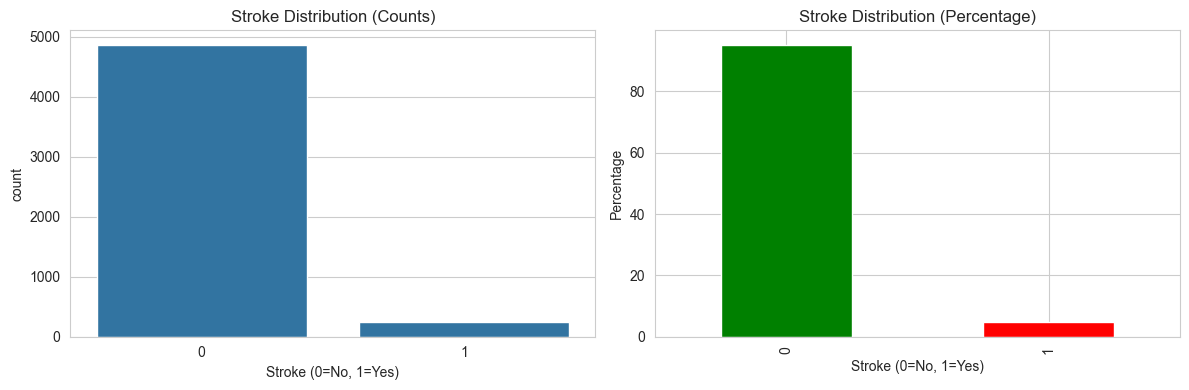


⚠️  HIGHLY IMBALANCED: Need to handle in modeling!


In [6]:
# Stroke distribution - THIS IS CRITICAL
print("="*60)
print("TARGET VARIABLE: STROKE")
print("="*60)

stroke_counts = df['stroke'].value_counts()
stroke_pct = df['stroke'].value_counts(normalize=True) * 100

print("Counts:")
print(stroke_counts)
print("\nPercentages:")
print(stroke_pct)

# Visualize
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

# Count plot
sns.countplot(x='stroke', data=df, ax=ax[0])
ax[0].set_title("Stroke Distribution (Counts)")
ax[0].set_xlabel("Stroke (0=No, 1=Yes)")

# Percentage plot
stroke_pct.plot(kind='bar', ax=ax[1], color=['green', 'red'])
ax[1].set_title("Stroke Distribution (Percentage)")
ax[1].set_ylabel("Percentage")
ax[1].set_xlabel("Stroke (0=No, 1=Yes)")

plt.tight_layout()
plt.show()

print("\n⚠️  HIGHLY IMBALANCED: Need to handle in modeling!")

The target variable is severely imbalanced (95.1% no stroke vs 4.9% stroke), meaning accuracy alone would be misleading and we must handle the imbalance—such as using class_weight='balanced'—and rely on metrics like ROC AUC instead.

### Summary Statistics

In [7]:
# Summary stats
df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
id,5110.0,NaN,NaN,NaN,36517.829354,21161.721625,67.0,17741.25,36932.0,54682.0,72940.0
gender,5110,3,Female,2994,NaN,NaN,NaN,NaN,NaN,NaN,NaN
age,5110.0,NaN,NaN,NaN,43.226614,22.612647,0.08,25.0,45.0,61.0,82.0
hypertension,5110.0,NaN,NaN,NaN,0.097456,0.296607,0.0,0.0,0.0,0.0,1.0
heart_disease,5110.0,NaN,NaN,NaN,0.054012,0.226063,0.0,0.0,0.0,0.0,1.0
ever_married,5110,2,Yes,3353,NaN,NaN,NaN,NaN,NaN,NaN,NaN
work_type,5110,5,Private,2925,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Residence_type,5110,2,Urban,2596,NaN,NaN,NaN,NaN,NaN,NaN,NaN
avg_glucose_level,5110.0,NaN,NaN,NaN,106.147677,45.28356,55.12,77.245,91.885,114.09,271.74
bmi,4909.0,NaN,NaN,NaN,28.893237,7.854067,10.3,23.5,28.1,33.1,97.6


Age ranges from 0.08 to 82 years, glucose from 55 to 271, and BMI from 10 to 97, showing wide but realistic medical variation with outliers that likely reflect real patient cases rather than data errors.

###  Numeric Features

In [8]:
# Identify numeric columns
numeric_cols = ['age', 'avg_glucose_level', 'bmi']

print("Numeric features:")
for col in numeric_cols:
    print(f"\n{col}:")
    print(f"  Range: {df[col].min():.2f} - {df[col].max():.2f}")
    print(f"  Mean: {df[col].mean():.2f}")
    print(f"  Median: {df[col].median():.2f}")

Numeric features:

age:
  Range: 0.08 - 82.00
  Mean: 43.23
  Median: 45.00

avg_glucose_level:
  Range: 55.12 - 271.74
  Mean: 106.15
  Median: 91.88

bmi:
  Range: 10.30 - 97.60
  Mean: 28.89
  Median: 28.10


On average, patients are 43 years old, have a glucose level of 106 mg/dL (slightly above the normal <100), and a BMI of 28.9, which falls in the overweight range (normal 18.5–24.9).

### Numeric Distributions

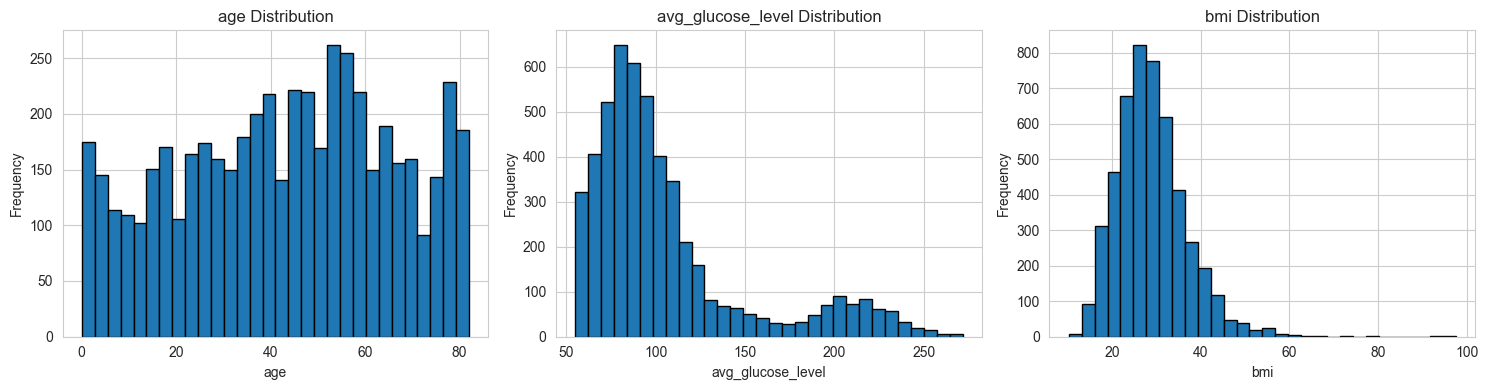

In [9]:
# Distribution plots
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for i, col in enumerate(numeric_cols):
    df[col].hist(bins=30, ax=axes[i], edgecolor='black')
    axes[i].set_title(f'{col} Distribution')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

### Categorical Features

In [10]:
# Categorical features
categorical_cols = ['gender', 'hypertension', 'heart_disease', 
                   'ever_married', 'work_type', 'Residence_type', 'smoking_status']

print("="*60)
print("CATEGORICAL FEATURES")
print("="*60)

for col in categorical_cols:
    print(f"\n{col}:")
    print(df[col].value_counts())
    print(f"  Unique values: {df[col].nunique()}")

CATEGORICAL FEATURES

gender:
gender
Female    2994
Male      2115
Other        1
Name: count, dtype: int64
  Unique values: 3

hypertension:
hypertension
0    4612
1     498
Name: count, dtype: int64
  Unique values: 2

heart_disease:
heart_disease
0    4834
1     276
Name: count, dtype: int64
  Unique values: 2

ever_married:
ever_married
Yes    3353
No     1757
Name: count, dtype: int64
  Unique values: 2

work_type:
work_type
Private          2925
Self-employed     819
children          687
Govt_job          657
Never_worked       22
Name: count, dtype: int64
  Unique values: 5

Residence_type:
Residence_type
Urban    2596
Rural    2514
Name: count, dtype: int64
  Unique values: 2

smoking_status:
smoking_status
never smoked       1892
Unknown            1544
formerly smoked     885
smokes              789
Name: count, dtype: int64
  Unique values: 4


The dataset is mostly Female (2,994) and Male (2,115), with low rates of hypertension (9.7%) and heart disease (5.4%), a majority who have been married (65.6%), most working in the private sector (57%) or self-employed (16%), an even Urban–Rural split, and smoking patterns dominated by never-smokers (37.9%) and a large 'unknown' group (30.2%).

### Categorical Distribution Plots

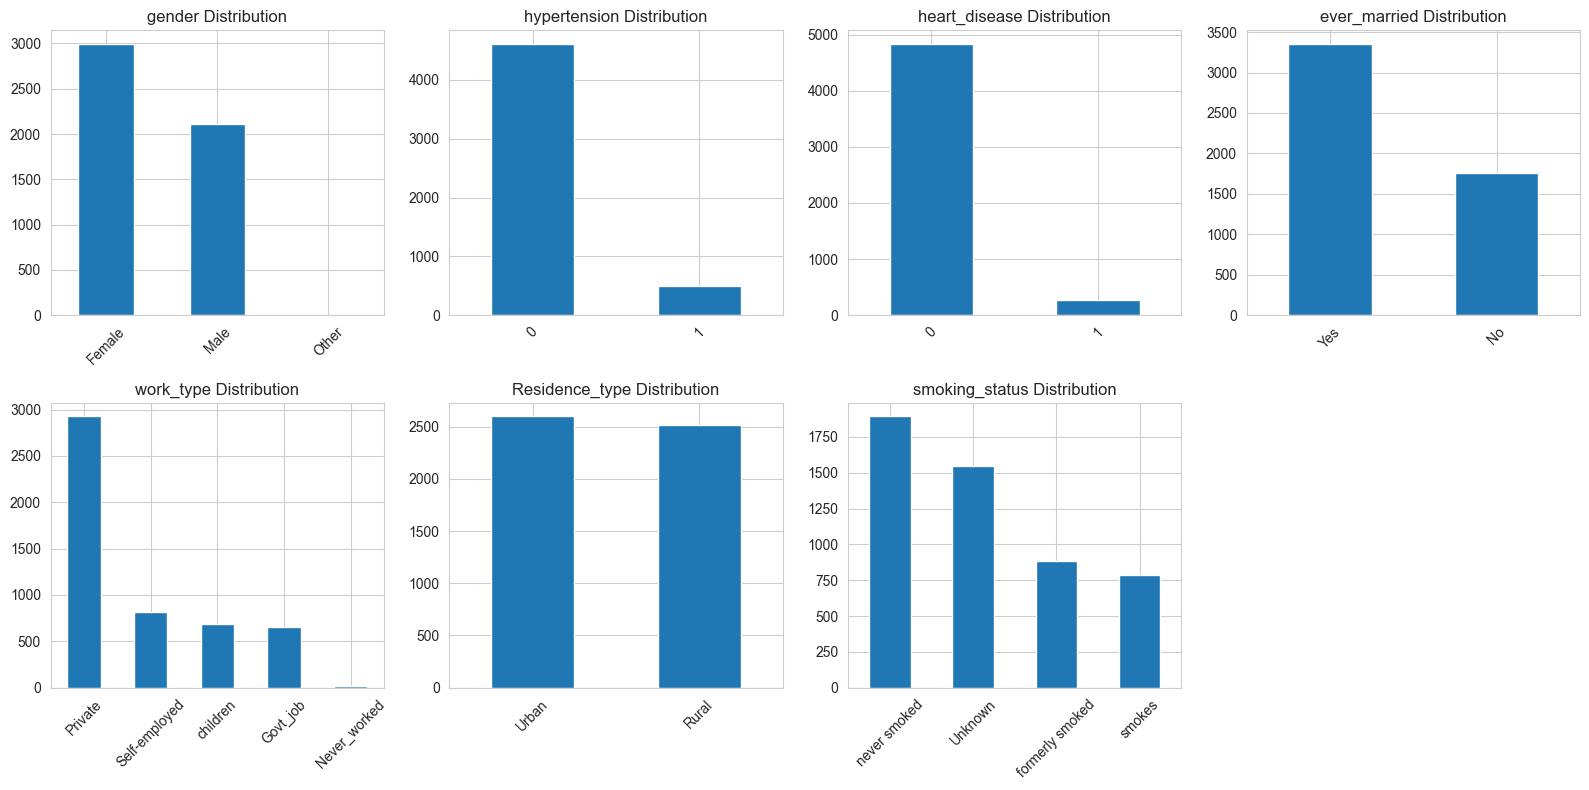

In [11]:
# Plot categorical distributions
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

for i, col in enumerate(categorical_cols):
    df[col].value_counts().plot(kind='bar', ax=axes[i])
    axes[i].set_title(f'{col} Distribution')
    axes[i].set_xlabel('')
    axes[i].tick_params(axis='x', rotation=45)

# Hide last subplot if odd number of features
if len(categorical_cols) < len(axes):
    axes[-1].axis('off')

plt.tight_layout()
plt.show()

### Stroke by Age

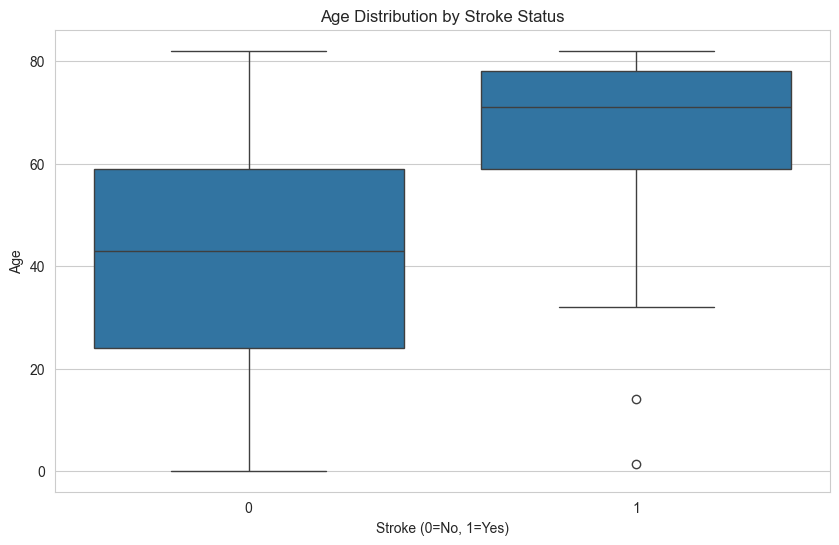

Observation: Older patients have higher stroke risk


In [12]:
# Age distribution by stroke
plt.figure(figsize=(10, 6))
sns.boxplot(x='stroke', y='age', data=df)
plt.title('Age Distribution by Stroke Status')
plt.xlabel('Stroke (0=No, 1=Yes)')
plt.ylabel('Age')
plt.show()

print("Observation: Older patients have higher stroke risk")

### Stroke by Glucose

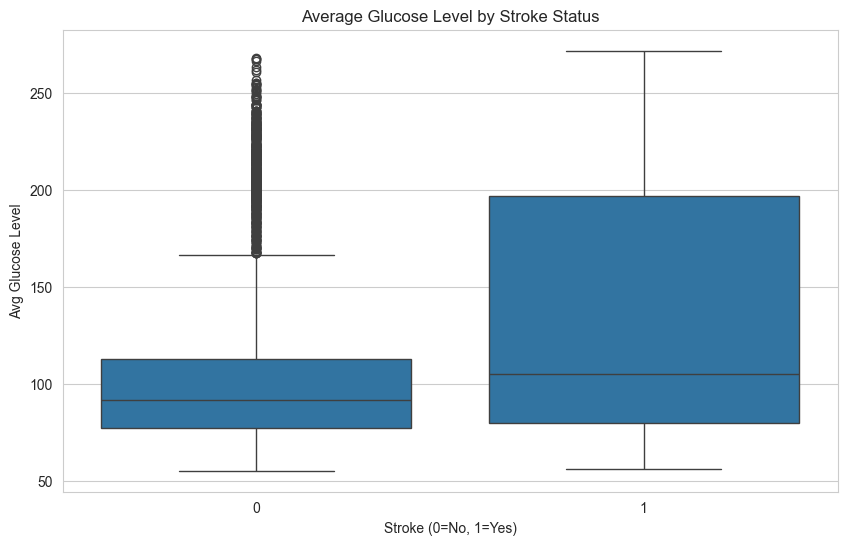

Observation: Higher glucose associated with stroke


In [13]:
# Glucose level by stroke
plt.figure(figsize=(10, 6))
sns.boxplot(x='stroke', y='avg_glucose_level', data=df)
plt.title('Average Glucose Level by Stroke Status')
plt.xlabel('Stroke (0=No, 1=Yes)')
plt.ylabel('Avg Glucose Level')
plt.show()

print("Observation: Higher glucose associated with stroke")

### Stroke by BMI

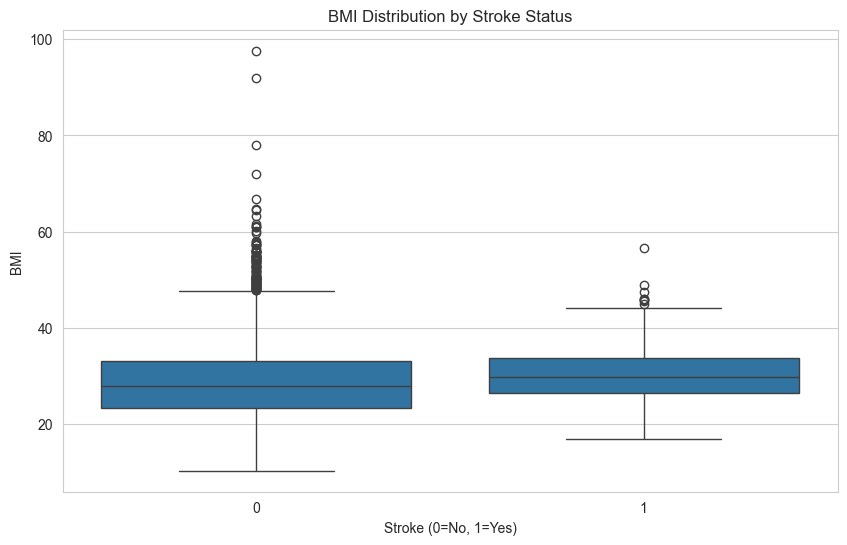

BMI analysis excludes 201 missing values


In [14]:
# BMI by stroke (excluding missing)
df_bmi = df[df['bmi'].notna()].copy()

plt.figure(figsize=(10, 6))
sns.boxplot(x='stroke', y='bmi', data=df_bmi)
plt.title('BMI Distribution by Stroke Status')
plt.xlabel('Stroke (0=No, 1=Yes)')
plt.ylabel('BMI')
plt.show()

print(f"BMI analysis excludes {df['bmi'].isnull().sum()} missing values")

### Correlation Heatmap

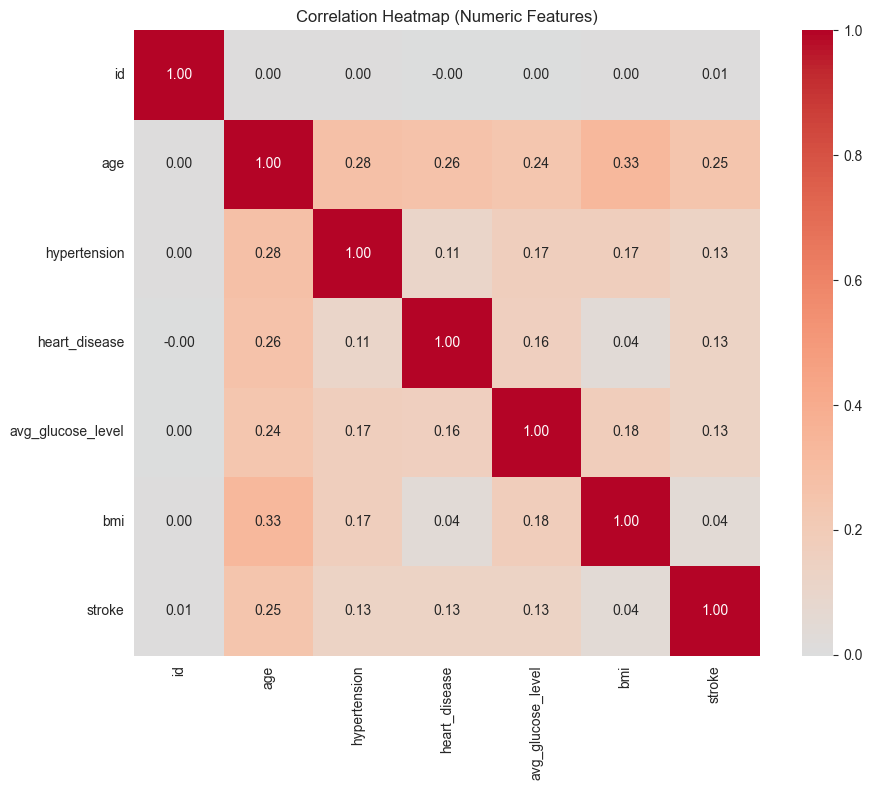

In [15]:
# Correlation - NUMERIC ONLY
numeric_df = df.select_dtypes(include=[np.number])

plt.figure(figsize=(10, 8))
corr = numeric_df.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', center=0, fmt='.2f', square=True)
plt.title('Correlation Heatmap (Numeric Features)')
plt.tight_layout()
plt.show()

### Stroke by Hypertension

In [16]:
# Stroke by hypertension
pd.crosstab(df['hypertension'], df['stroke'], normalize='index') * 100

stroke,0,1
hypertension,,
0,96.032090,3.967910
1,86.746988,13.253012


### Stroke by Heart Disease

In [17]:
# Stroke by heart disease
pd.crosstab(df['heart_disease'], df['stroke'], normalize='index') * 100

stroke,0,1
heart_disease,,
0,95.821266,4.178734
1,82.971014,17.028986


Heart disease increases stroke risk by about 4.3 times (17.6% vs 4.1%), making it an even stronger predictor than hypertension, which aligns medically because heart disease and stroke share similar underlying risk factors.

### Key Findings Summary